<a href="https://colab.research.google.com/github/catastropiyush/TransformerAsOn/blob/master/Phase_transitions_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile requirements.txt
scipy
matplotlib
datasets
vllm
accelerate>=0.26.0

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import os
import json
import numpy as np
from huggingface_hub import snapshot_download
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"

import torch
import torch.distributed as dist
from datasets import load_dataset
from vllm import LLM, SamplingParams

!mkdir -p "/content/models"
!mkdir -p "/content/outputs"

def download_model(model_name):
    print(f"Downloading {model_name}...")
    local_path = f"/content/models/{model_name.split('/')[-1]}"

    if not os.path.exists(local_path):
        snapshot_download(
            repo_id=model_name,
            local_dir=local_path,
            ignore_patterns=["*.md", "*.pt", "*.bin", "*.txt"],
        )
    return local_path

# Set and download model
model_name = "Qwen/Qwen2.5-0.5B"
#model_name = "meta-llama/Llama-3.2-1B"
local_model_path = download_model(model_name)
print(f"Model downloaded to {local_model_path}")

# Load the dataset
ds = load_dataset("sentence-transformers/simple-wiki")

# Initialize LLM
llm = LLM(
    model=local_model_path,
    trust_remote_code=True,
    max_model_len=2048,
    tensor_parallel_size=1,
    dtype="float16"
)

def gen_with_T(T, max_tokens=1024):
    T = float("%.4f"%(T))
    params = SamplingParams(
        n=1,
        temperature=T,
        max_tokens=max_tokens,
        min_tokens=max_tokens-1,
        seed=42,
        skip_special_tokens=True
    )

    model_family = model_name.split("/")[-2]
    file_perfix = model_name.split("/")[-1]

    # Store outputs locally in Colab
    output_dir = f"/content/outputs/{model_family}"
    os.makedirs(output_dir, exist_ok=True)
    fname = f"{output_dir}/{file_perfix}-T{T}.json"

    if os.path.exists(fname):
        print(f"{fname} already exists, skipping")
        return

    try:
        # Take a smaller subset for Colab
        sample_texts = [i for i in ds['train']['text']][::2000]
        outputs = llm.generate(sample_texts, params)

        data = []
        for output in outputs:
            prompt = output.prompt
            generated = output.outputs[0]
            data.append({
                "prompt": prompt,
                "generated": generated.text
            })

        with open(fname, "w") as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"saved to {fname}")

    finally:
        if dist.is_initialized():
            dist.destroy_process_group()

if __name__=="__main__":
    for T in np.linspace(0, 10, 6):
        gen_with_T(T)

    for T in np.linspace(0, 2, 11):
        gen_with_T(T)

print("\nGenerated files:")
!ls -R /content/outputs

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

Model downloaded to /content/models/Qwen2.5-0.5B


README.md:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/102225 [00:00<?, ? examples/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Processed prompts: 100%|██████████| 52/52 [00:16<00:00,  3.12it/s, est. speed input: 101.25 toks/s, output: 3190.19 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.0.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  3.05it/s, est. speed input: 99.05 toks/s, output: 3120.98 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T2.0.json


Processed prompts: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s, est. speed input: 92.67 toks/s, output: 2919.73 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T4.0.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.98it/s, est. speed input: 96.87 toks/s, output: 3052.20 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T6.0.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s, est. speed input: 95.54 toks/s, output: 3010.29 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T8.0.json


Processed prompts: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s, est. speed input: 93.28 toks/s, output: 2939.10 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T10.0.json
/content/outputs/Qwen/Qwen2.5-0.5B-T0.0.json already exists, skipping


Processed prompts: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s, est. speed input: 92.10 toks/s, output: 2901.79 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.2.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s, est. speed input: 95.98 toks/s, output: 3024.15 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.4.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.92it/s, est. speed input: 94.83 toks/s, output: 2987.81 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.6.json


Processed prompts: 100%|██████████| 52/52 [00:18<00:00,  2.85it/s, est. speed input: 92.74 toks/s, output: 2921.95 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T0.8.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.95it/s, est. speed input: 95.81 toks/s, output: 3018.63 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.0.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.96it/s, est. speed input: 96.35 toks/s, output: 3035.73 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.2.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.90it/s, est. speed input: 94.18 toks/s, output: 2967.32 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.4.json


Processed prompts: 100%|██████████| 52/52 [00:18<00:00,  2.83it/s, est. speed input: 91.92 toks/s, output: 2896.05 toks/s]


saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.6.json


Processed prompts: 100%|██████████| 52/52 [00:17<00:00,  2.94it/s, est. speed input: 95.70 toks/s, output: 3015.28 toks/s]

saved to /content/outputs/Qwen/Qwen2.5-0.5B-T1.8.json
/content/outputs/Qwen/Qwen2.5-0.5B-T2.0.json already exists, skipping

Generated files:
/content/outputs:
Qwen

/content/outputs/Qwen:
Qwen2.5-0.5B-T0.0.json	Qwen2.5-0.5B-T0.8.json	 Qwen2.5-0.5B-T1.4.json  Qwen2.5-0.5B-T4.0.json
Qwen2.5-0.5B-T0.2.json	Qwen2.5-0.5B-T10.0.json  Qwen2.5-0.5B-T1.6.json  Qwen2.5-0.5B-T6.0.json
Qwen2.5-0.5B-T0.4.json	Qwen2.5-0.5B-T1.0.json	 Qwen2.5-0.5B-T1.8.json  Qwen2.5-0.5B-T8.0.json
Qwen2.5-0.5B-T0.6.json	Qwen2.5-0.5B-T1.2.json	 Qwen2.5-0.5B-T2.0.json


In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [ ]:
!pip install transformers
!pip install tqdm

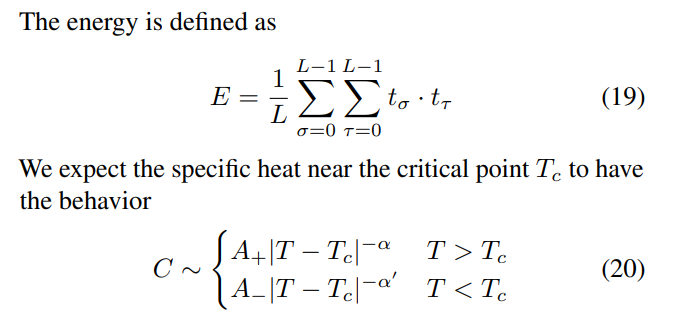

using Qwen/Qwen2.5-0.5B


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.0.json: 1023.92
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.2.json: 1023.90
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.4.json: 1023.79
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.6.json: 1023.27
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T0.8.json: 1023.50
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.0.json: 1022.37
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.2.json: 1027.69
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.4.json: 1031.65
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.6.json: 1035.88
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T1.8.json: 1040.33
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T2.0.json: 1043.12
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T4.0.json: 1057.23
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T6.0.json: 1060.25
avg length for /content/outputs/Qwen/Qwen2.5-0.5B-T8.0.json: 1063.52
avg length for /content/outputs/Qw

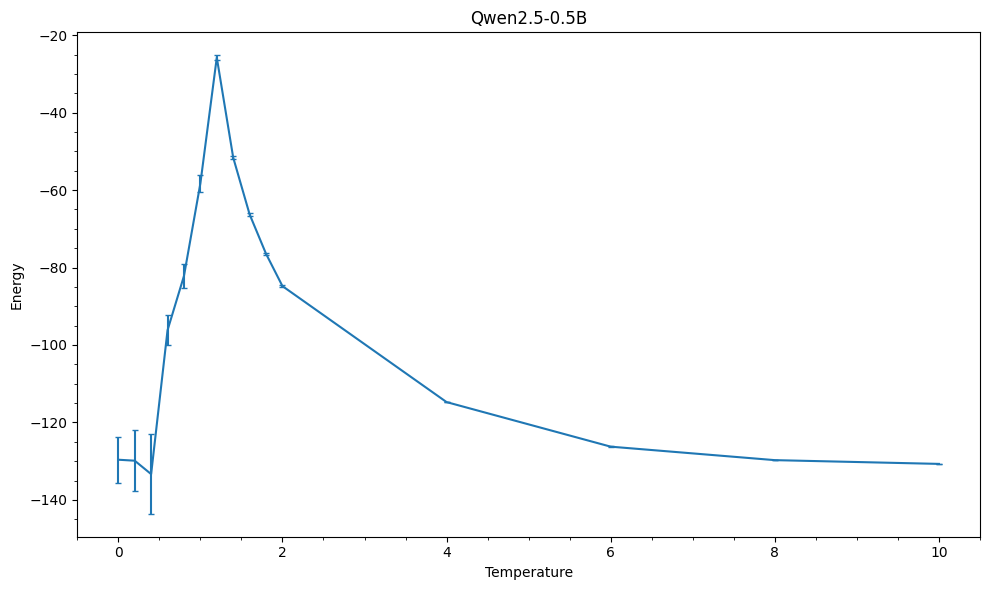


Generated files:
/content/data:
Qwen-energy.json
/content/plots:
energy_Qwen2.5-0.5B-0-10.pdf


In [ ]:
import os
import re
import math
import json
import numpy as np
from matplotlib import pyplot as plt

import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# Create output directories
!mkdir -p "/content/data"
!mkdir -p "/content/plots"

model_name = os.getenv("model_name", "Qwen/Qwen2.5-0.5B")  # Default model if not set
#model_name = os.getenv("model_name", "meta-llama/Llama-3.2-1B")  # Default model if not set
print("using %s"%(model_name))

if not model_name[0].isalpha():
    model_name = os.path.expanduser(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto"
)
embed_tokens = model.get_input_embeddings()

def get_files(dir, file_perfix):
    text_files = []
    for i in os.listdir("/content/outputs/%s"%(dir)):  # Changed path to Colab directory
        r = re.search("%s-T([0-9\.]+?)\.json"%(file_perfix), i)
        if not r:
            continue
        T = float(r.group(1))
        text_files.append({
            "T": T,
            "path": "/content/outputs/%s/%s"%(dir,i)  # Changed path to Colab directory
        })
    text_files.sort(key=lambda x: x["T"])
    return text_files

def load_json(filename):
    if os.path.exists(filename):
        with open(filename, "r") as f:
            data = json.load(f)
    else:
        data = {}
    return data

def add_log(filename, entry, data):
    json_data = load_json(filename)
    if entry not in json_data:
        json_data[entry] = data
    else:
        json_data[entry] = {**json_data[entry], **data}

    lines = []
    for k, v in json_data.items():
        lines.append("\"%s\": %s"%(k, json.dumps(v)))
    with open(filename, "w") as f:
        f.write("{\n")
        f.write(",\n".join(lines))
        f.write("\n}")

def energy(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    with torch.no_grad():
        energies = []
        lengths  = []
        for d in data:
            model_inputs  = tokenizer(d["generated"], return_tensors="pt").to(model.device)
            inputs_embeds = embed_tokens(model_inputs["input_ids"]) # 1, len, 1536
            inputs_embeds = inputs_embeds.squeeze(0)
            inputs_embeds/= torch.linalg.vector_norm(inputs_embeds, dim = -1, keepdim = True)
            attn = -inputs_embeds@inputs_embeds.T # attn[i,j] = ei cdot ej
            attn.fill_diagonal_(0.0)
            e = (attn.sum()/attn.shape[0]).item()
            energies.append(e)
            lengths.append(attn.shape[0])
    print("avg length for %s: %.2f"%(filename, np.mean(lengths)))
    return np.mean(energies), np.std(energies)/math.sqrt(len(data))

def susceptibility(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    N = 512
    with torch.no_grad():
        spins = []
        for d in data:
            model_inputs  = tokenizer(d["generated"], return_tensors="pt").to(model.device)
            inputs_embeds = embed_tokens(model_inputs["input_ids"]) # 1, len, 1536
            inputs_embeds = inputs_embeds.squeeze(0)
            inputs_embeds/= torch.linalg.vector_norm(inputs_embeds, dim = -1, keepdim = True)
            spins.append(inputs_embeds[-N:,:]) # N x 896

    spins = torch.stack(spins)
    spinsbar = spins.mean(dim=0)
    deltaspins = spins - spinsbar # 103 x 1000 x 896
    sisj = []
    for i in range(N):
        for j in range(i+1,N):
            sisj.append((deltaspins[:,i,:]*deltaspins[:,j,:]).sum(dim=-1).mean().item())
    return np.mean(sisj)

def plot_energy(plot_flag=True):
    dir, file_perfix = model_name.split("/")[-2:] # Qwen, Qwen2.5-32B
    text_files = get_files(dir, file_perfix)

    betas, energies, sigmas = [], [], []
    for i in text_files:
        T, path = i["T"], i["path"]
        e, s = energy(path)
        betas.append(T)
        energies.append(e)
        sigmas.append(s)

    print(list(zip(betas, [float("%2.f"%(e)) for e in energies])))

    # Save energy data to local Colab directory
    energy_file = "/content/data/%s-energy.json"%(dir)
    add_log(energy_file, file_perfix, {
        "model_size": model.num_parameters(exclude_embeddings=True),
        "betas": betas,
        "energies": energies,
        "sigmas": sigmas
    })

    if not plot_flag:
        return

    Tmin = round(min(betas))
    Tmax = round(max(betas))

    plt.figure(figsize=(10, 6))
    plt.errorbar(betas, energies, yerr=sigmas, capsize=2)
    plt.minorticks_on()
    #plt.grid(True, which="both")
    plt.xlabel("Temperature")
    plt.ylabel("Energy")
    plt.title(file_perfix)
    plt.tight_layout()

    plot_path = f"/content/plots/energy_{file_perfix}-{Tmin}-{Tmax}.pdf"
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")

    plt.show()

if __name__=="__main__":
    plot_energy()

print("\nGenerated files:")
!ls -R /content/data
!ls -R /content/plots

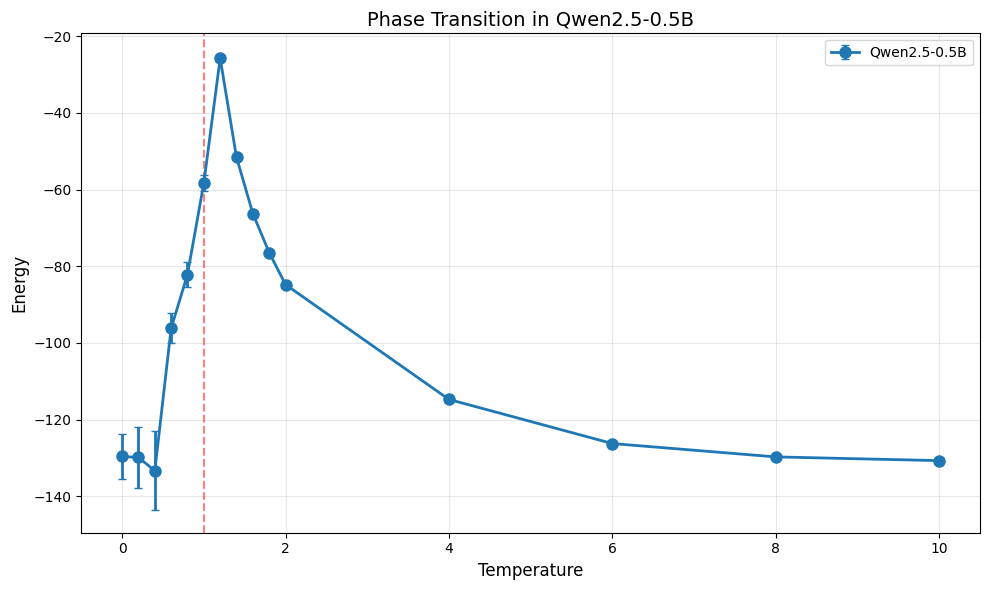

Estimated critical temperature: 1.00


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the energy data
def load_energy_data(model_family="Qwen"):
    with open(f"/content/data/{model_family}-energy.json", "r") as f:
        data = json.load(f)
    return data

def plot_phase_transition(model_family="Qwen", model_size="Qwen2.5-0.5B"):
    data = load_energy_data(model_family)
    model_data = data[model_size]

    # Extract data
    temperatures = np.array(model_data['betas'])
    energies = np.array(model_data['energies'])
    errors = np.array(model_data['sigmas'])

    plt.figure(figsize=(10, 6))
    plt.errorbar(temperatures, energies, yerr=errors,
                fmt='o-', capsize=3, markersize=8,
                linewidth=2, label=model_size)

    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Energy', fontsize=12)
    plt.title(f'Phase Transition in {model_size}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add vertical line at potential critical temperature
    critical_temp = temperatures[np.argmax(np.gradient(energies))]
    plt.axvline(x=critical_temp, color='r', linestyle='--',
                alpha=0.5, label=f'Tc ≈ {critical_temp:.2f}')

    plt.tight_layout()
    plt.show()

    print(f"Estimated critical temperature: {critical_temp:.2f}")


plot_phase_transition()

# models = ["Qwen2.5-0.5B", "Qwen2.5-1.5B", "Qwen2.5-7B"]
# for model in models:
#     plot_phase_transition(model_size=model)

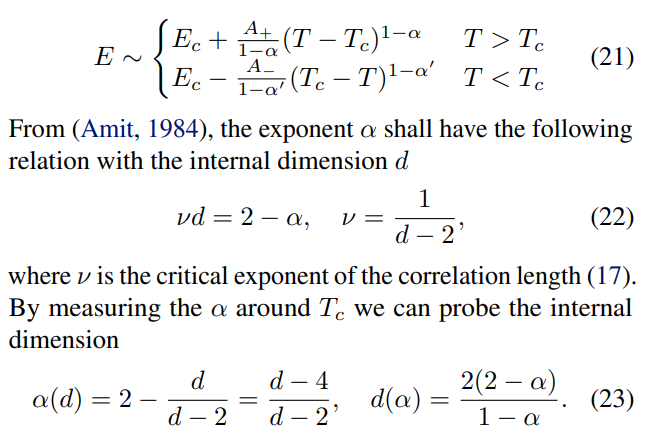

100%|██████████| 15/15 [02:37<00:00, 10.51s/it]


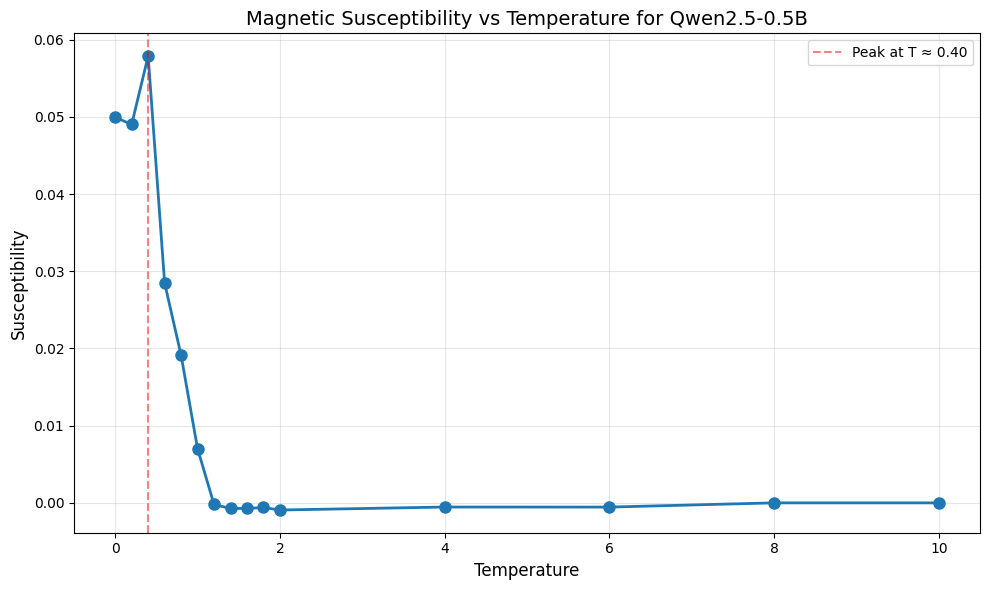

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_susceptibility(model_name="Qwen/Qwen2.5-0.5B"):
    dir, file_perfix = model_name.split("/")[-2:]
    text_files = []

    # Get files
    for i in os.listdir(f"/content/outputs/{dir}"):
        r = re.search(f"{file_perfix}-T([0-9\.]+?)\.json", i)
        if not r:
            continue
        T = float(r.group(1))
        text_files.append({
            "T": T,
            "path": f"/content/outputs/{dir}/{i}"
        })
    text_files.sort(key=lambda x: x["T"])

    # Calculate susceptibility for each temperature
    temperatures = []
    susceptibilities = []

    for file_info in tqdm(text_files):
        T = file_info["T"]
        chi = susceptibility(file_info["path"])  # Using the existing susceptibility function
        temperatures.append(T)
        susceptibilities.append(chi)

    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, susceptibilities, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Susceptibility', fontsize=12)
    plt.title(f'Magnetic Susceptibility vs Temperature for {file_perfix}', fontsize=14)
    plt.grid(True, alpha=0.3)

    peak_idx = np.argmax(susceptibilities)
    peak_temp = temperatures[peak_idx]
    plt.axvline(x=peak_temp, color='r', linestyle='--',
                alpha=0.5, label=f'Peak at T ≈ {peak_temp:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return temperatures, susceptibilities

# Run the analysis
temps, suscs = calculate_susceptibility()